# Image Classification using Rubbish Augmented Dataset

**Dataset**: [rubbish-dataset](https://huggingface.co/datasets/Jotadebeese/rubbish_augmented)

This notebook demonstrates a complete image classification pipeline to achieve **95%+ accuracy** on rubbish dataset.

## 1. Import Libraries

In [81]:
!pip install split-folders

import os
import json
import shutil
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
import splitfolders
import zipfile
from huggingface_hub import hf_hub_download

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Data loading from Huggingface Dataset

In [82]:
# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running in local environment")

# Set base directory based on environment
if IN_COLAB:
    # In Colab, use /content directory
    WORK_DIR = '/content'
else:
    # In local, use current directory
    WORK_DIR = '.'

# Update BASE_DIR to use WORK_DIR
BASE_DIR = os.path.join(WORK_DIR, 'dataset_final')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

if not os.path.exists(BASE_DIR):
    print(f"\nDataset not found at: {BASE_DIR}")
    print("Downloading dataset from Hugging Face...")
    print("This may take a few minutes (dataset size: ~500MB)...\n")

    try:
        zip_path = hf_hub_download(
            repo_id="Jotadebeese/rubbish_augmented",
            filename="rubbish_dataset_augmented.zip",
            repo_type="dataset"
        )

        print(f"Download complete: {zip_path}")
        print("Extracting dataset...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            zip_ref.extractall(WORK_DIR)
            print(f"Extracted {len(file_list)} files")

        extracted_dirs = [d for d in os.listdir(WORK_DIR) if os.path.isdir(os.path.join(WORK_DIR, d))]

        possible_dataset_dirs = ['dataset', 'rubbish_dataset_augmented', 'data']
        for dir_name in extracted_dirs:
            if any(name in dir_name.lower() for name in possible_dataset_dirs):
                potential_base = os.path.join(WORK_DIR, dir_name)

                # Check if it has train/val/test subdirectories
                if all(os.path.exists(os.path.join(potential_base, split))
                       for split in ['train', 'validation', 'test']):
                    BASE_DIR = potential_base
                    TRAIN_DIR = os.path.join(BASE_DIR, 'train')
                    VAL_DIR = os.path.join(BASE_DIR, 'validation')
                    TEST_DIR = os.path.join(BASE_DIR, 'test')
                    break

        print(f"\nDataset downloaded and extracted to: {BASE_DIR}")

        # Clean up corrupted files
        print("\nCleaning up corrupted files...")
        corrupted_count = 0

        for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
            if os.path.exists(split_dir):
                for class_name in os.listdir(split_dir):
                    class_path = os.path.join(split_dir, class_name)
                    if os.path.isdir(class_path):
                        for filename in os.listdir(class_path):
                            file_path = os.path.join(class_path, filename)
                            try:
                                # Try to open as image
                                from PIL import Image
                                with Image.open(file_path) as img:
                                    img.verify()
                            except Exception:
                                # If it fails, it's corrupted - delete it
                                os.remove(file_path)
                                corrupted_count += 1

        if corrupted_count > 0:
            print(f"Removed {corrupted_count} corrupted files")
        else:
            print("No corrupted files found")

    except Exception as e:
        print(f"\n Error downloading dataset: {e}")
        print("\nPlease manually download the dataset from:")
        print("https://huggingface.co/datasets/Jotadebeese/rubbish_augmented")
        raise
else:
    print(f"\n Dataset already exists at: {BASE_DIR}")
    print("\nSkipping download...")

input_folder = 'rubbish_dataset_augmented'
output_folder = 'dataset_final'

del_folder = 'rubbish_dataset_augmented/trash'

# Deteting trash folder
if os.path.exists(del_folder):
    shutil.rmtree(del_folder)
    print(f"\nFolder '{del_folder}' deleted.")
else:
    print("\nFolder not found.")

splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.8, .1, .1),
                   group_prefix=None, move=False)

# Verify dataset structure
print("\nDATASET VERIFICATION")
print(f"Base directory: {BASE_DIR}")
print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(VAL_DIR)}")
print(f"Test directory exists: {os.path.exists(TEST_DIR)}")

if all(os.path.exists(d) for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    print(f"\n✓ Dataset structure verified!")
    print(f"Train classes: {len(os.listdir(TRAIN_DIR))}")
    print(f"Validation classes: {len(os.listdir(VAL_DIR))}")
    print(f"Test classes: {len(os.listdir(TEST_DIR))}")
else:
    print(f"Dataset structure incomplete!")

Running in Google Colab

 Dataset already exists at: /content/dataset_final

Skipping download...

Folder not found.


Copying files: 23066 files [00:43, 536.10 files/s]


DATASET VERIFICATION
Base directory: /content/dataset_final
Train directory exists: True
Validation directory exists: True
Test directory exists: True

✓ Dataset structure verified!
Train classes: 6
Validation classes: 6
Test classes: 6


## 3. Configuration

In [83]:
# Seed for reproducibility
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Model parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 6
EPOCHS = 50
LEARNING_RATE = 1e-4
ACCURACY_THRESHOLD = 0.95

## 4. Dataset Analysis

In [84]:
# Count images in each split
def count_images(directory):
    total = 0
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            total += count
    return total, class_counts

train_total, train_classes = count_images(TRAIN_DIR)
val_total, val_classes = count_images(VAL_DIR)
test_total, test_classes = count_images(TEST_DIR)

print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Training images: {train_total}")
print(f"Validation images: {val_total}")
print(f"Test images: {test_total}")
print(f"Total images: {train_total + val_total + test_total}")
print(f"\nNumber of classes: {len(train_classes)}")
print("\nClass distribution (Training):")
for class_name, count in sorted(train_classes.items()):
    print(f"  {class_name}: {count}")
print("=" * 60)

DATASET STATISTICS
Training images: 18450
Validation images: 2304
Test images: 2312
Total images: 23066

Number of classes: 6

Class distribution (Training):
  cardboard: 2619
  glass: 4539
  metal: 2524
  organic: 2953
  paper: 3382
  plastic: 2433


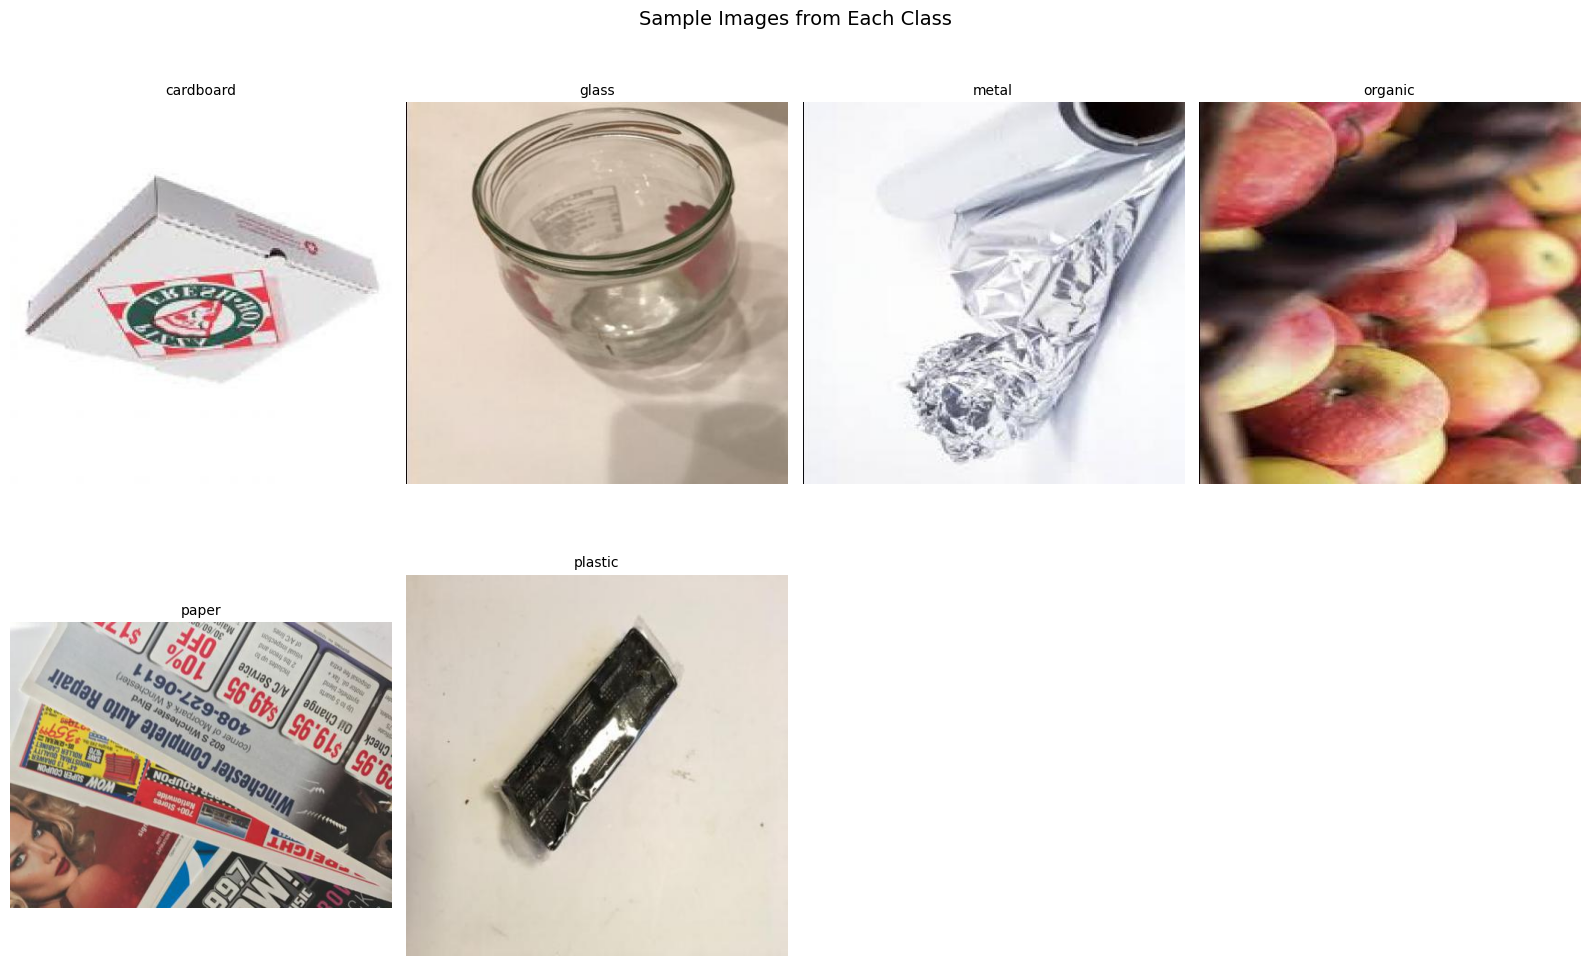

In [85]:
# Visualize sample images from each class
class_names = sorted(os.listdir(TRAIN_DIR))
plt.figure(figsize=(16, 10))

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(TRAIN_DIR, class_name)
    image_files = os.listdir(class_path)
    sample_image = os.path.join(class_path, image_files[0])

    img = Image.open(sample_image)
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name.replace('rubbish__', '').replace('_', ' '), fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Each Class', fontsize=14, y=1.02)
plt.show()

## 5. Data Augmentation & Generators

In [86]:
# Training data generator with aggressive augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

# Calculate steps to ensure 10,000+ samples per epoch
STEPS_PER_EPOCH = max(train_generator.samples // BATCH_SIZE, 10000 // BATCH_SIZE)

print(f"\n{'='*60}")
print("DATA GENERATOR CONFIGURATION")
print(f"{'='*60}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nSteps per epoch: {STEPS_PER_EPOCH}")
print(f"Effective training samples per epoch: {STEPS_PER_EPOCH * BATCH_SIZE}")
print(f"\n✓ Meets 10,000+ image requirement: {STEPS_PER_EPOCH * BATCH_SIZE >= 10000}")
print(f"{'='*60}")

Found 18445 images belonging to 6 classes.
Found 2303 images belonging to 6 classes.
Found 2311 images belonging to 6 classes.

DATA GENERATOR CONFIGURATION
Training samples: 18445
Validation samples: 2303
Test samples: 2311

Steps per epoch: 288
Effective training samples per epoch: 18432

✓ Meets 10,000+ image requirement: True


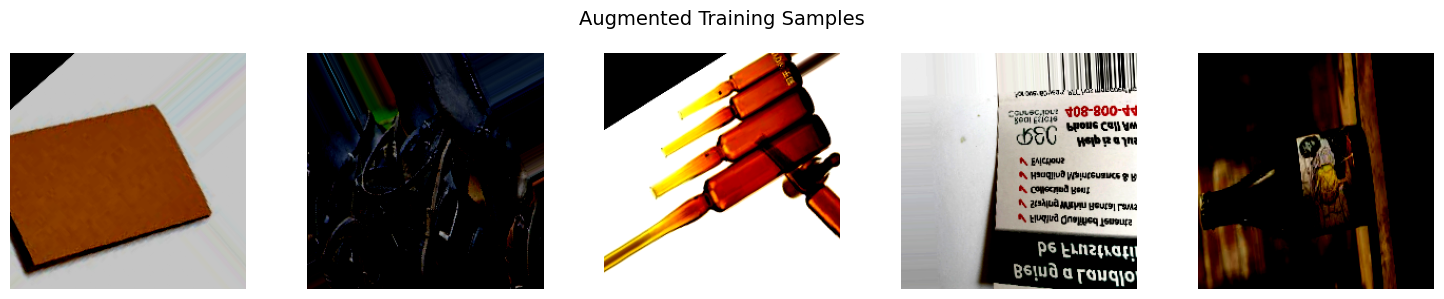

In [87]:
# Visualize augmentation effects
sample_batch, _ = next(train_generator)
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_batch[i])
    plt.axis('off')
plt.suptitle('Augmented Training Samples', fontsize=14)
plt.tight_layout()
plt.show()

In [88]:
print("="*60)
print("COMPUTING CLASS WEIGHTS")
print("="*60)
# 1. Hitung bobot berdasarkan data training
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
# 2. Ubah ke format dictionary untuk Keras
class_weight_dict = dict(enumerate(class_weights))
# 3. Tampilkan hasil
print("\nClass Weights:")
class_names = list(train_generator.class_indices.keys())
for idx, (class_name, weight) in enumerate(zip(class_names, class_weights)):
    clean_name = class_name.replace('Tomato___', '').replace('_', ' ')
    print(f"  {idx}. {clean_name:<35s} : {weight:.4f}")
print(f"\n✓ Class weights computed successfully")
print(f"  Dictionary: {class_weight_dict}")
print("="*60)

COMPUTING CLASS WEIGHTS

Class Weights:
  0. cardboard                           : 1.1760
  1. glass                               : 0.6773
  2. metal                               : 1.2180
  3. organic                             : 1.0410
  4. paper                               : 0.9090
  5. plastic                             : 1.2635

✓ Class weights computed successfully
  Dictionary: {0: np.float64(1.1760392756949758), 1: np.float64(0.6772784019975031), 2: np.float64(1.2179741151611199), 3: np.float64(1.0410317191556608), 4: np.float64(0.9089789079440174), 5: np.float64(1.2635292505822715)}


## 6. Model Architecture

**Architecture**: Sequential model combining:
1. **MobileNetV2** (pre-trained on ImageNet, frozen)
2. **Custom Conv2D + MaxPooling** (meets Dicoding requirements)
3. **GlobalAveragePooling2D** (reduces parameters)
4. **Dense layers** with Dropout for classification

In [89]:
# Base model (MobileNetV2 without top layers)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = True

for layer in base_model.layers[:50]:
    layer.trainable = False

model = models.Sequential([
    base_model,

    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='custom_conv'),
    layers.MaxPooling2D(pool_size=(2, 2), name='custom_pool'),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Classification head
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')

], name='RubbishClassifier')

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "RubbishClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv (Conv2D)            │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_pool (MaxPooling2D)      │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,274,694 (20.12 MB)

 Trainable params: 5,191,302 (19.80 MB)

 Non-trainable params: 83,392 (325.75 KB)

## 7. Custom Callback Implementation

**AccuracyThresholdCallback**: Automatically stops training when both training and validation accuracy reach 95%.

In [90]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):

    def __init__(self, threshold=0.95):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)

        if train_acc >= self.threshold and val_acc >= self.threshold:
            print(f"\n{'='*60}")
            print(f"✓ TARGET ACHIEVED!")
            print(f"  Training Accuracy: {train_acc:.4f} (>= {self.threshold})")
            print(f"  Validation Accuracy: {val_acc:.4f} (>= {self.threshold})")
            print(f"  Stopping training at epoch {epoch + 1}")
            print(f"{'='*60}\n")
            self.model.stop_training = True

print("✓ AccuracyThresholdCallback created successfully")
print(f"  Threshold: {ACCURACY_THRESHOLD * 100}%")

✓ AccuracyThresholdCallback created successfully
  Threshold: 95.0%


## 8. Model Training

Training with callbacks:
1. **AccuracyThresholdCallback**: Auto-stop at 95%
2. **ModelCheckpoint**: Save best model
3. **EarlyStopping**: Prevent overfitting

In [91]:
# Setup callbacks
callbacks = [
    AccuracyThresholdCallback(threshold=ACCURACY_THRESHOLD),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model
print("\nStarting training...\n")
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✓ Training completed!")


Starting training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5654 - loss: 1.2416

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.84889, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.5659 - loss: 1.2402 - val_accuracy: 0.8489 - val_loss: 0.4740 - learning_rate: 1.0000e-04
Epoch 2/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step - accuracy: 0.8594 - loss: 0.3952

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.84889
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.8594 - loss: 0.3952 - val_accuracy: 0.8472 - val_loss: 0.4775 - learning_rate: 1.0000e-04
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8453 - loss: 0.4576
Epoch 3: val_accuracy improved from 0.84889 to 0.87929, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.8453 - loss: 0.4575 - val_accuracy: 0.8793 - val_loss: 0.3870 - learning_rate: 1.0000e-04
Epoch 4/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - accuracy: 0.9219 - loss: 0.2487

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy improved from 0.87929 to 0.88016, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9219 - loss: 0.2487 - val_accuracy: 0.8802 - val_loss: 0.3829 - learning_rate: 1.0000e-04
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8868 - loss: 0.3382
Epoch 5: val_accuracy improved from 0.88016 to 0.90621, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.8868 - loss: 0.3382 - val_accuracy: 0.9062 - val_loss: 0.3205 - learning_rate: 1.0000e-04
Epoch 6/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 45s 159ms/step - accuracy: 0.9219 - loss: 0.3412

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_accuracy improved from 0.90621 to 0.90751, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9219 - loss: 0.3412 - val_accuracy: 0.9075 - val_loss: 0.3202 - learning_rate: 1.0000e-04
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9122 - loss: 0.2640
Epoch 7: val_accuracy improved from 0.90751 to 0.92314, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9122 - loss: 0.2640 - val_accuracy: 0.9231 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 8/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - accuracy: 0.8750 - loss: 0.2489

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.92314
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8750 - loss: 0.2489 - val_accuracy: 0.9223 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9259 - loss: 0.2248
Epoch 9: val_accuracy did not improve from 0.92314
288/288 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.9259 - loss: 0.2248 - val_accuracy: 0.9101 - val_loss: 0.3319 - learning_rate: 1.0000e-04
Epoch 10/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.8438 - loss: 0.4830

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy did not improve from 0.92314

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
288/288 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.8438 - loss: 0.4830 - val_accuracy: 0.9092 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9425 - loss: 0.1773
Epoch 11: val_accuracy improved from 0.92314 to 0.93574, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.9425 - loss: 0.1773 - val_accuracy: 0.9357 - val_loss: 0.2351 - learning_rate: 2.0000e-05
Epoch 12/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 43s 152ms/step - accuracy: 0.9531 - loss: 0.1929

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_accuracy did not improve from 0.93574
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9531 - loss: 0.1929 - val_accuracy: 0.9357 - val_loss: 0.2348 - learning_rate: 2.0000e-05
Epoch 13/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9531 - loss: 0.1434
Epoch 13: val_accuracy improved from 0.93574 to 0.94485, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9531 - loss: 0.1433 - val_accuracy: 0.9449 - val_loss: 0.1973 - learning_rate: 2.0000e-05
Epoch 14/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - accuracy: 0.9688 - loss: 0.1084

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_accuracy did not improve from 0.94485
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9688 - loss: 0.1084 - val_accuracy: 0.9444 - val_loss: 0.1972 - learning_rate: 2.0000e-05
Epoch 15/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9509 - loss: 0.1396
Epoch 15: val_accuracy improved from 0.94485 to 0.94963, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9509 - loss: 0.1395 - val_accuracy: 0.9496 - val_loss: 0.1746 - learning_rate: 2.0000e-05
Epoch 16/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step - accuracy: 0.9688 - loss: 0.1859

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_accuracy did not improve from 0.94963
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9688 - loss: 0.1859 - val_accuracy: 0.9496 - val_loss: 0.1748 - learning_rate: 2.0000e-05
Epoch 17/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9582 - loss: 0.1219
Epoch 17: val_accuracy did not improve from 0.94963
288/288 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.9582 - loss: 0.1219 - val_accuracy: 0.9483 - val_loss: 0.1718 - learning_rate: 2.0000e-05
Epoch 18/50
  1/288 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - accuracy: 0.9531 - loss: 0.0792

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: val_accuracy did not improve from 0.94963
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9531 - loss: 0.0792 - val_accuracy: 0.9488 - val_loss: 0.1714 - learning_rate: 2.0000e-05
Epoch 19/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9626 - loss: 0.1101
✓ TARGET ACHIEVED!
  Training Accuracy: 0.9602 (>= 0.95)
  Validation Accuracy: 0.9553 (>= 0.95)
  Stopping training at epoch 19


Epoch 19: val_accuracy improved from 0.94963 to 0.95528, saving model to best_model.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9625 - loss: 0.1101 - val_accuracy: 0.9553 - val_loss: 0.1562 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 19.

✓ Training completed!


## 9. Training Visualization

Visualize training progress.

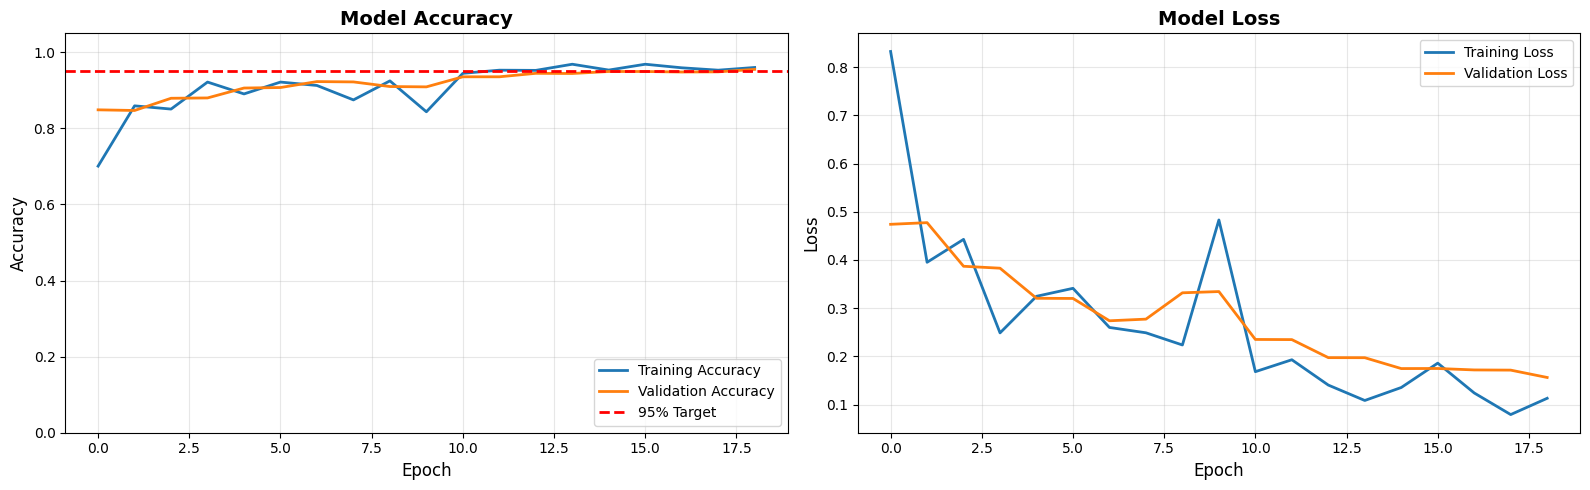


FINAL TRAINING METRICS
Training Accuracy: 0.9602 (96.02%)
Validation Accuracy: 0.9553 (95.53%)
Training Loss: 0.1130
Validation Loss: 0.1562

✓ Accuracy >= 95%: True


In [92]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Target', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n{'='*60}")
print("FINAL TRAINING METRICS")
print(f"{'='*60}")
print(f"Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"\n✓ Accuracy >= 95%: {final_train_acc >= 0.95 and final_val_acc >= 0.95}")
print(f"{'='*60}")

In [93]:
# Generate Confusion Matrix and Classification Report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print("Generating predictions for confusion matrix...")

# Reset test generator to start from beginning
test_generator.reset()

# Get predictions
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())
class_names_clean = [name.replace('Tomato___', '').replace('_', ' ') for name in class_names]

print(f"\n✓ Generated {len(y_pred_classes)} predictions")
print(f"✓ Number of classes: {len(class_names_clean)}")

Generating predictions for confusion matrix...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 815ms/step

✓ Generated 2311 predictions
✓ Number of classes: 6


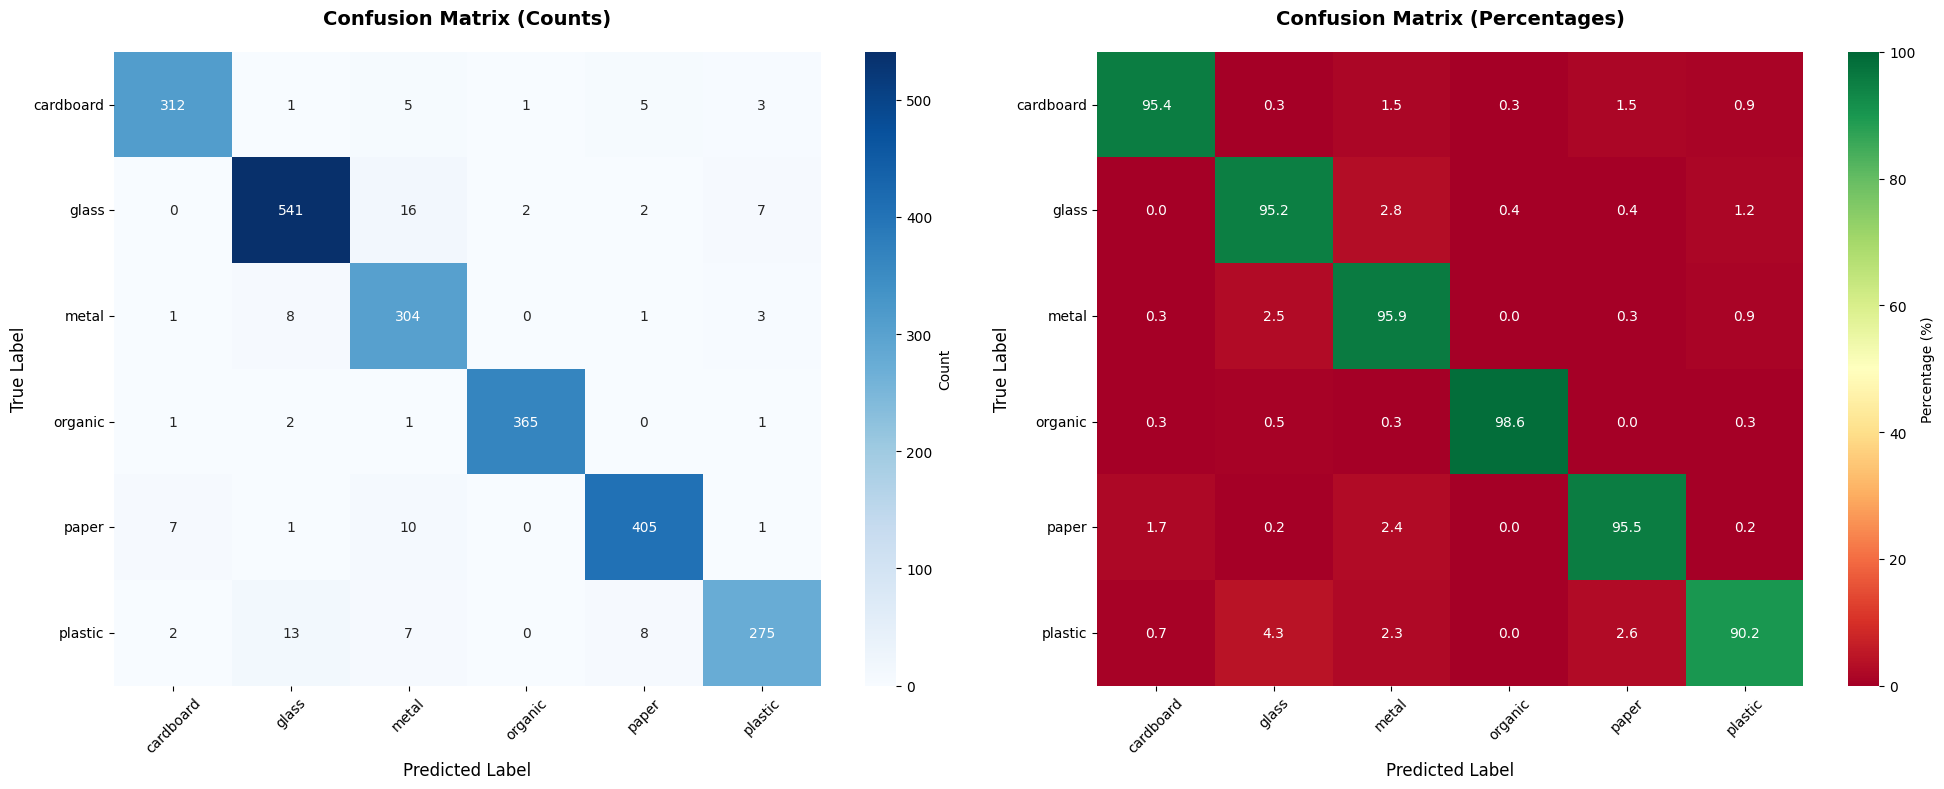


✓ Confusion matrix saved as: confusion_matrix.png


In [94]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Confusion Matrix (Counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_clean,
            yticklabels=class_names_clean,
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot 2: Confusion Matrix (Percentages)
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=class_names_clean,
            yticklabels=class_names_clean,
            cbar_kws={'label': 'Percentage (%)'},
            vmin=0, vmax=100,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved as: confusion_matrix.png")

In [95]:
# Generate classification report
print(f"\n{'='*80}")
print("CLASSIFICATION REPORT")
print(f"{'='*80}\n")

report = classification_report(y_true, y_pred_classes,
                               target_names=class_names_clean,
                               digits=4)
print(report)

# Create detailed classification report as DataFrame
report_dict = classification_report(y_true, y_pred_classes,
                                    target_names=class_names_clean,
                                    output_dict=True)

df_report = pd.DataFrame(report_dict).transpose()
df_report = df_report.round(4)

print(f"\n{'='*80}")
print("DETAILED METRICS PER CLASS")
print(f"{'='*80}\n")
print(df_report.to_string())


CLASSIFICATION REPORT

              precision    recall  f1-score   support

   cardboard     0.9659    0.9541    0.9600       327
       glass     0.9558    0.9525    0.9541       568
       metal     0.8863    0.9590    0.9212       317
     organic     0.9918    0.9865    0.9892       370
       paper     0.9620    0.9552    0.9586       424
     plastic     0.9483    0.9016    0.9244       305

    accuracy                         0.9528      2311
   macro avg     0.9517    0.9515    0.9512      2311
weighted avg     0.9536    0.9528    0.9529      2311


DETAILED METRICS PER CLASS

              precision  recall  f1-score    support
cardboard        0.9659  0.9541    0.9600   327.0000
glass            0.9558  0.9525    0.9541   568.0000
metal            0.8863  0.9590    0.9212   317.0000
organic          0.9918  0.9865    0.9892   370.0000
paper            0.9620  0.9552    0.9586   424.0000
plastic          0.9483  0.9016    0.9244   305.0000
accuracy         0.9528  0.9528  

## 10. Model Evaluation on Test Set

In [96]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*60}")
print("TEST SET EVALUATION")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"\n✓ Test Accuracy >= 95%: {test_accuracy >= 0.95}")
print(f"{'='*60}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 738ms/step - accuracy: 0.9560 - loss: 0.1602

TEST SET EVALUATION
Test Accuracy: 0.9528 (95.28%)
Test Loss: 0.1660

✓ Test Accuracy >= 95%: True


## 11. Model Deployment (3 Formats)

Export model in three required formats:
1. **SavedModel** (TensorFlow native format)
2. **TF-Lite** (Mobile/Edge deployment)
3. **TensorFlow.js** (Web deployment)

In [97]:
deployment_dirs = {
    'saved_model': 'saved_model',
    'tflite': 'tflite',
    'tfjs': 'tfjs_model'
}
# Create directories
for dir_name in deployment_dirs.values():
    os.makedirs(dir_name, exist_ok=True)
    print(f"✓ Created directory: {dir_name}/")

✓ Created directory: saved_model/
✓ Created directory: tflite/
✓ Created directory: tfjs_model/


In [98]:
try:
    # For Keras 3.x - use export()
    model.export('saved_model')
    print("✓ SavedModel exported to: saved_model/")
except AttributeError:
    # Fallback for older Keras versions - use save()
    model.save('saved_model', save_format='tf')
    print("✓ SavedModel saved to: saved_model/")
print(f"  - saved_model.pb")
print(f"  - variables/")
# Verify SavedModel structure
if os.path.exists('saved_model/saved_model.pb'):
    pb_size = os.path.getsize('saved_model/saved_model.pb') / (1024 * 1024)
    print(f"  - Model size: {pb_size:.2f} MB")
elif os.path.exists('saved_model'):
    # Calculate total size
    total_size = 0
    for dirpath, dirnames, filenames in os.walk('saved_model'):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    print(f"  - Total size: {total_size/(1024*1024):.2f} MB")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_643')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138369754512464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369373786512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369754511888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369373785744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369754508432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138366789268112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369373783056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369373786896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369754510544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138369373782672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138366602985296

In [99]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

tflite_path = 'tflite/model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)

print(f"TF-Lite model saved to: {tflite_path}")
print(f"Size: {tflite_size:.2f} MB")

labels_path = 'tflite/labels.txt'
class_names = sorted(train_generator.class_indices.keys())
with open(labels_path, 'w') as f:
    for class_name in class_names:

        clean_name = class_name.replace('Tomato___', '').replace('_', ' ')
        f.write(f"{clean_name}\n")
print(f"Labels file saved to: {labels_path}")
print(f"Number of classes: {len(class_names)}")

TF-Lite model saved to: tflite/model.tflite
Size: 19.96 MB
Labels file saved to: tflite/labels.txt
Number of classes: 6


In [100]:
try:
    # Install tensorflowjs if needed
    import subprocess
    import sys
    subprocess.run([sys.executable, "-m", "pip", "install", "-q",
                   "tensorflowjs==4.20.0"], check=True, capture_output=True)

    import tensorflowjs as tfjs

    tfjs.converters.save_keras_model(model, 'tfjs_model')

    print("TensorFlow.js model saved to: tfjs_model/")

    tfjs_files = os.listdir('tfjs_model')
    for file in tfjs_files:
        file_path = os.path.join('tfjs_model', file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path) / 1024
            print(f"  - {file} ({size:.2f} KB)")

except Exception as e:
    print(f"TensorFlow.js conversion failed: {e}")
    print("Trying alternative method...")

    try:
        os.system('pip install -q tensorflowjs==4.20.0')
        os.system('tensorflowjs_converter --input_format=keras saved_model tfjs_model')
        print("TensorFlow.js model saved to: tfjs_model/")
    except:
        print("TensorFlow.js conversion skipped")


failed to lookup keras version from the file,
    this is likely a weight only file
TensorFlow.js model saved to: tfjs_model/
  - model.json (157.36 KB)
  - group1-shard2of6.bin (4096.00 KB)
  - group1-shard5of6.bin (4096.00 KB)
  - group1-shard3of6.bin (4096.00 KB)
  - group1-shard6of6.bin (124.27 KB)
  - group1-shard1of6.bin (4096.00 KB)
  - group1-shard4of6.bin (4096.00 KB)


## 12. Inference Demonstration

Demonstrate model inference on new images.

In [101]:
print("="*80)
print("INFERENCE DEMONSTRATION - TF-LITE MODEL")
print("="*80)

# Load TF-Lite model
tflite_model_path = 'tflite/model.tflite'
labels_path = 'tflite/labels.txt'

# Initialize TF-Lite interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n✓ TF-Lite model loaded from: {tflite_model_path}")
print(f"\nModel Input Details:")
print(f"  - Shape: {input_details[0]['shape']}")
print(f"  - Type: {input_details[0]['dtype']}")
print(f"\nModel Output Details:")
print(f"  - Shape: {output_details[0]['shape']}")
print(f"  - Type: {output_details[0]['dtype']}")

# Load class labels
with open(labels_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

print(f"\n✓ Loaded {len(class_names)} class labels")
print(f"\nClasses:")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name}")

print("\n" + "="*80)

INFERENCE DEMONSTRATION - TF-LITE MODEL

✓ TF-Lite model loaded from: tflite/model.tflite

Model Input Details:
  - Shape: [  1 224 224   3]
  - Type: <class 'numpy.float32'>

Model Output Details:
  - Shape: [1 6]
  - Type: <class 'numpy.float32'>

✓ Loaded 6 class labels

Classes:
  0: cardboard
  1: glass
  2: metal
  3: organic
  4: paper
  5: plastic



/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [102]:
def predict_with_tflite(image_path, interpreter, class_names, top_k=3):
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized, dtype=np.float32)

    # Normalize to [-1, 1]
    preprocess_input(img_array)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Set input tensor
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run inference
    interpreter.invoke()

    # Get output
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get top-k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Image with prediction
    axes[0].imshow(img)
    axes[0].axis('off')

    predicted_class = class_names[top_indices[0]]
    confidence = predictions[top_indices[0]] * 100

    title = f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%"
    axes[0].set_title(title, fontsize=13, fontweight='bold', pad=10)

    # Add border color based on confidence
    if confidence >= 95:
        border_color = '#2ecc71'  # Green
    elif confidence >= 80:
        border_color = '#f39c12'  # Orange
    else:
        border_color = '#e74c3c'  # Red

    for spine in axes[0].spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(4)

    # Plot 2: Top-k predictions bar chart
    top_classes = [class_names[i] for i in top_indices]
    top_probs = [predictions[i] * 100 for i in top_indices]

    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(top_k)]
    bars = axes[1].barh(range(top_k), top_probs, color=colors, alpha=0.8, edgecolor='black')

    axes[1].set_yticks(range(top_k))
    axes[1].set_yticklabels(top_classes)
    axes[1].set_xlabel('Confidence (%)', fontsize=11, fontweight='bold')
    axes[1].set_title(f'Top-{top_k} Predictions', fontsize=13, fontweight='bold', pad=10)
    axes[1].set_xlim([0, 100])
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')

    # Add percentage labels on bars
    for i, (bar, prob) in enumerate(zip(bars, top_probs)):
        axes[1].text(prob + 2, i, f'{prob:.2f}%',
                    va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\n{'='*70}")
    print("PREDICTION RESULTS (TF-Lite Model)")
    print(f"{'='*70}")
    print(f"Image: {image_path}")
    print(f"\nTop-{top_k} Predictions:")
    for i, (cls, prob) in enumerate(zip(top_classes, top_probs), 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{emoji} {i}. {cls:<30s} : {prob:6.2f}%")
    print(f"{'='*70}\n")

    return predictions

print("✓ Prediction function created")

✓ Prediction function created



TESTING INFERENCE ON RANDOM TEST IMAGES

Testing on 5 random images...


################################################################################
TEST IMAGE 1/5
################################################################################
True Class: glass


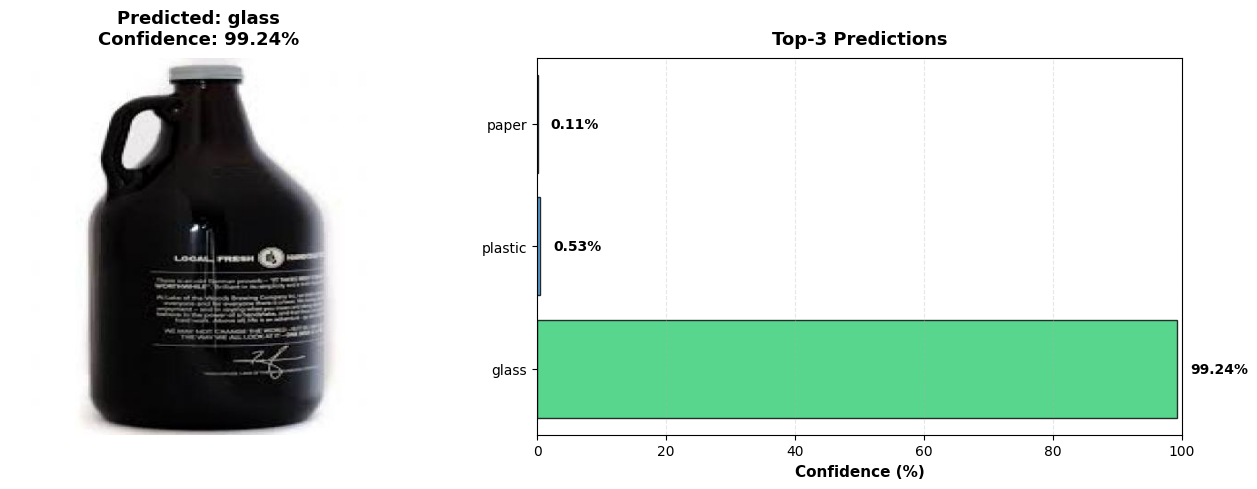


PREDICTION RESULTS (TF-Lite Model)
Image: /content/dataset_final/test/glass/image_10271.jpg

Top-3 Predictions:
🥇 1. glass                          :  99.24%
🥈 2. plastic                        :   0.53%
🥉 3. paper                          :   0.11%


################################################################################
TEST IMAGE 2/5
################################################################################
True Class: cardboard


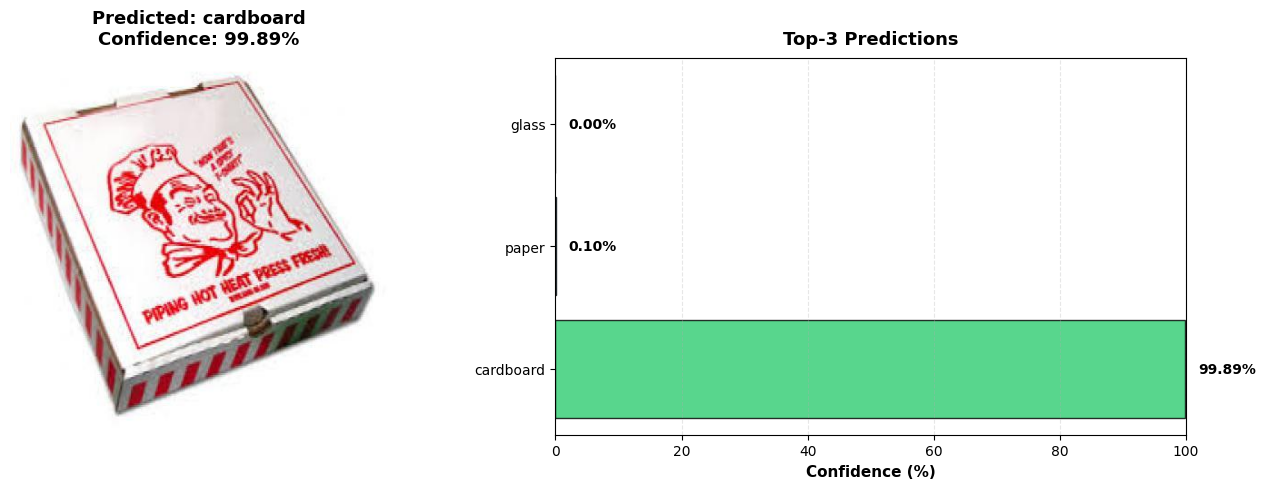


PREDICTION RESULTS (TF-Lite Model)
Image: /content/dataset_final/test/cardboard/image_5620.jpg

Top-3 Predictions:
🥇 1. cardboard                      :  99.89%
🥈 2. paper                          :   0.10%
🥉 3. glass                          :   0.00%


################################################################################
TEST IMAGE 3/5
################################################################################
True Class: metal


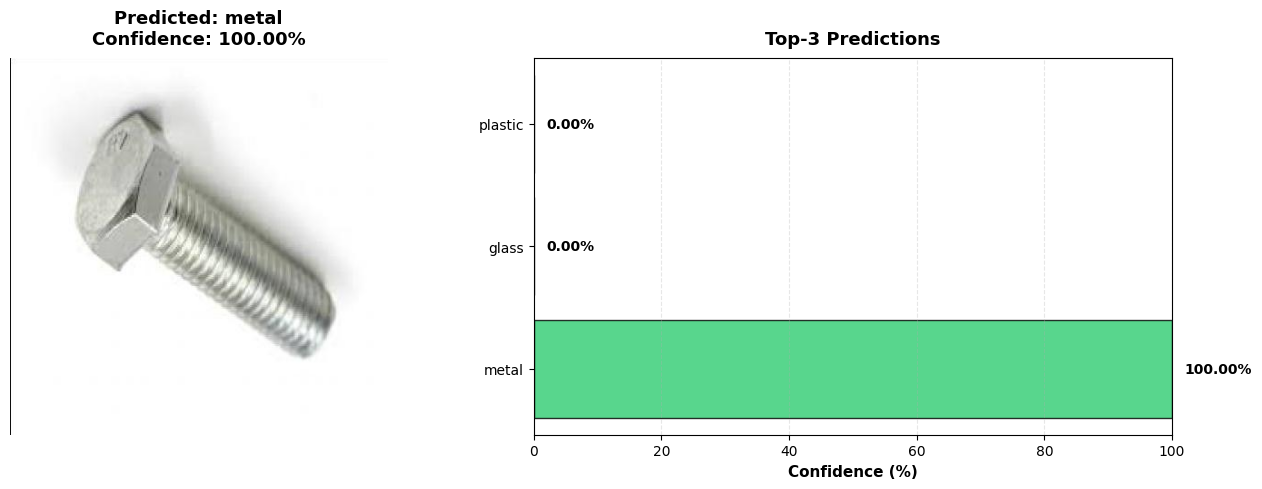


PREDICTION RESULTS (TF-Lite Model)
Image: /content/dataset_final/test/metal/image_13253.jpg

Top-3 Predictions:
🥇 1. metal                          : 100.00%
🥈 2. glass                          :   0.00%
🥉 3. plastic                        :   0.00%


################################################################################
TEST IMAGE 4/5
################################################################################
True Class: plastic


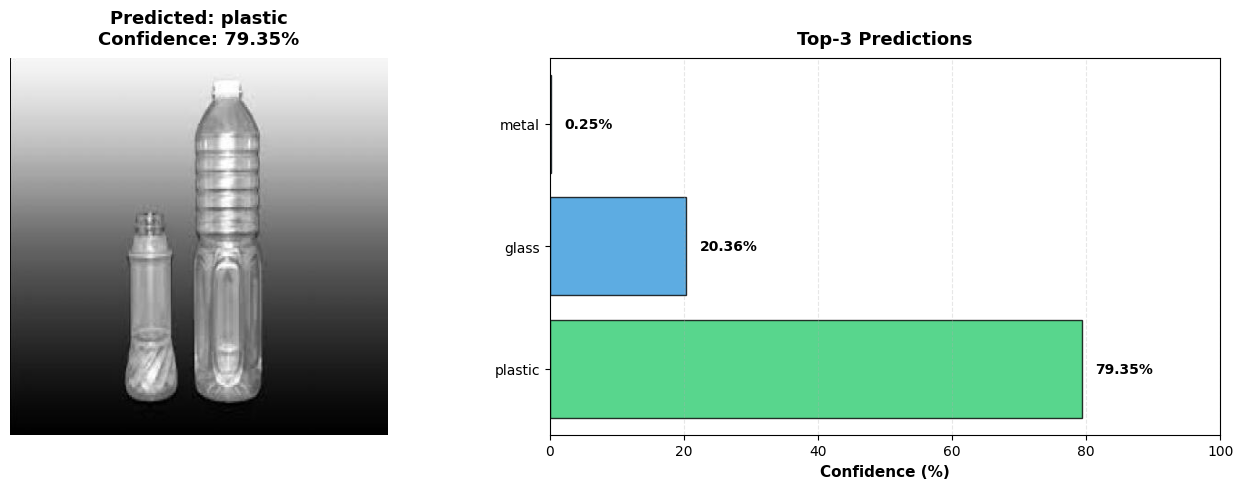


PREDICTION RESULTS (TF-Lite Model)
Image: /content/dataset_final/test/plastic/image_19132.jpg

Top-3 Predictions:
🥇 1. plastic                        :  79.35%
🥈 2. glass                          :  20.36%
🥉 3. metal                          :   0.25%


################################################################################
TEST IMAGE 5/5
################################################################################
True Class: organic


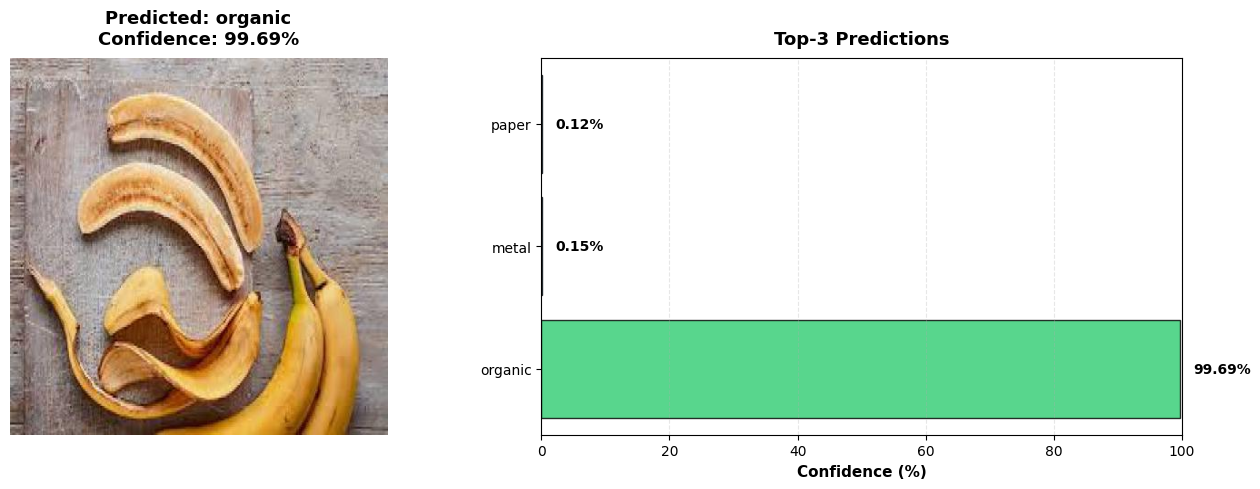


PREDICTION RESULTS (TF-Lite Model)
Image: /content/dataset_final/test/organic/image_1075.jpg

Top-3 Predictions:
🥇 1. organic                        :  99.69%
🥈 2. metal                          :   0.15%
🥉 3. paper                          :   0.12%



In [103]:
# Test inference on random test images
print("\n" + "="*80)
print("TESTING INFERENCE ON RANDOM TEST IMAGES")
print("="*80)

# Get random test images from different classes
test_images = []
for class_name in os.listdir(TEST_DIR)[:5]:  # Test 5 different classes
    class_path = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            # Get a random image
            random_image = np.random.choice(images)
            image_path = os.path.join(class_path, random_image)
            test_images.append({
                'path': image_path,
                'true_class': class_name.replace('Tomato___', '').replace('_', ' ')
            })

print(f"\nTesting on {len(test_images)} random images...\n")

# Run predictions
for idx, test_img in enumerate(test_images, 1):
    print(f"\n{'#'*80}")
    print(f"TEST IMAGE {idx}/{len(test_images)}")
    print(f"{'#'*80}")
    print(f"True Class: {test_img['true_class']}")

    predictions = predict_with_tflite(
        test_img['path'],
        interpreter,
        class_names,
        top_k=3
    )


UPLOAD YOUR OWN IMAGE FOR TESTING

Upload an image of a tomato leaf to test the model:


Saving glass.png to glass (1).png

Processing uploaded image: glass (1).png


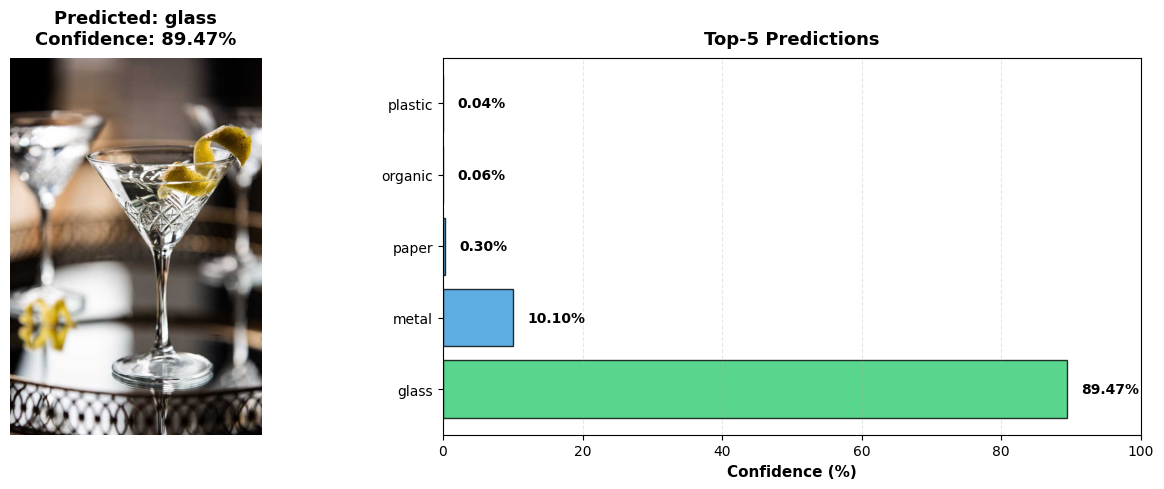


PREDICTION RESULTS (TF-Lite Model)
Image: glass (1).png

Top-5 Predictions:
🥇 1. glass                          :  89.47%
🥈 2. metal                          :  10.10%
🥉 3. paper                          :   0.30%
🥉 4. organic                        :   0.06%
🥉 5. plastic                        :   0.04%



In [104]:
# Interactive image upload for testing
print("\n" + "="*80)
print("UPLOAD YOUR OWN IMAGE FOR TESTING")
print("="*80)

try:
    from google.colab import files
    import io

    print("\nUpload an image of a tomato leaf to test the model:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n{'='*70}")
        print(f"Processing uploaded image: {filename}")
        print(f"{'='*70}")

        # Save uploaded file
        with open(filename, 'wb') as f:
            f.write(uploaded[filename])

        # Run prediction
        predictions = predict_with_tflite(filename, interpreter, class_names, top_k=5)

except ImportError:
    print("\nNot running in Google Colab")
    print("To test with your own image locally, use:")
    print("  predict_with_tflite('path/to/your/image.jpg', interpreter, class_names)")